![](https://pm4py.fit.fraunhofer.de/static/assets/images/pm4py-site-logo-padded.png)

# 1. Setup

## 1.1 Packages

In [1]:
# general
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import pm4py

# data
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.objects.log.importer.xes import importer as xes_importer

# process mining
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery

# viz
from pm4py.visualization.petrinet import visualizer as pn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

# misc
from pm4py.objects.conversion.process_tree import converter as pt_converter

#from pm4py.objects.petri import semantics
#from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
#from pm4py.objects.conversion.process_tree import converter as pt_converter
#from pm4py.objects.petri import semantics

## 1.2 Versions

In [2]:
print(f'platform     {sys.platform}')
print(f'environment  {sys.prefix}')
print(f'python       {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}')
print(f'pandas       {pd.__version__}')
print(f'matplotlib   {sys.modules["matplotlib"].__version__}')
print(f'pm4py        {pm4py.__version__}')

platform     linux
environment  /home/rene/miniconda3/envs/datascience
python       3.8.5
pandas       1.2.0
matplotlib   3.3.2
pm4py        2.1.3.2


## 1.3 Directories

In [3]:
directories = ['log', 'output']

In [4]:
for directory in directories:
    if not os.path.isdir(directory):
        os.mkdir(directory)

## 1.4 Display

In [5]:
pd.set_option('display.max_rows', 50)

# 2. Read Data

In [6]:
log_csv = pd.read_csv('data/running-example.csv', sep=';')

# 3. Explore Data

In [7]:
# Shape
log_csv.shape

(42, 5)

In [8]:
# Check NA-values
log_csv.isna().sum()

case_id      0
activity     0
timestamp    0
costs        0
resource     0
dtype: int64

In [9]:
# Information
log_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   case_id    42 non-null     int64 
 1   activity   42 non-null     object
 2   timestamp  42 non-null     object
 3   costs      42 non-null     int64 
 4   resource   42 non-null     object
dtypes: int64(2), object(3)
memory usage: 1.8+ KB


In [10]:
# Sample data
log_csv.sample(n=7)

,case_id,activity,timestamp,costs,resource
12,2,decide,2011-01-05 11:22:00+01:00,200,Sara
29,5,check ticket,2011-01-14 14:33:00+01:00,100,Ellen
40,4,decide,2011-01-09 12:02:00+01:00,200,Sara
35,5,decide,2011-01-23 13:12:00+01:00,200,Sara
27,5,decide,2011-01-10 13:28:00+01:00,200,Sara
30,5,examine casually,2011-01-16 15:50:00+01:00,400,Mike
6,3,check ticket,2011-01-08 11:43:00+01:00,100,Pete


In [11]:
# Unique values
pd.DataFrame({
    'unique values': [log_csv[col].nunique() for col in log_csv.columns],
    'fraction': [round(log_csv[col].nunique() / log_csv.shape[0], 2) for col in log_csv.columns]},
    index = log_csv.columns
)

,unique values,fraction
case_id,6,0.14
activity,8,0.19
timestamp,41,0.98
costs,4,0.10
resource,6,0.14


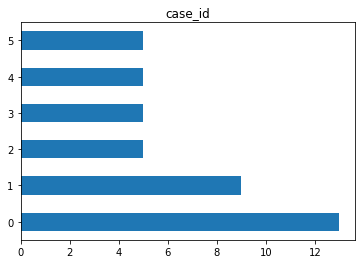

In [12]:
# Value counts: case_id
log_csv.case_id.value_counts().reset_index(drop=True).plot(y='case_id', kind='barh', title='case_id')
plt.show()

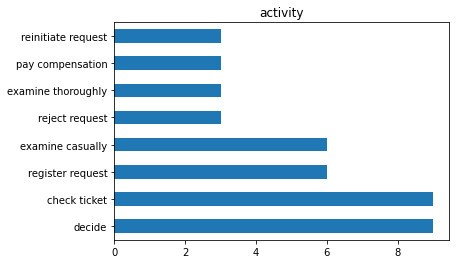

In [13]:
# Value counts: activity
log_csv.activity.value_counts().plot(y='activity', kind='barh', title='activity')
plt.show()

In [14]:
# Unique values: timestamp
log_csv.timestamp.nunique()

41

In [15]:
# Multiple occurences: timestamp
log_csv.timestamp.value_counts()[log_csv.timestamp.value_counts() > 1]

2011-01-06 15:02:00+01:00    2
Name: timestamp, dtype: int64

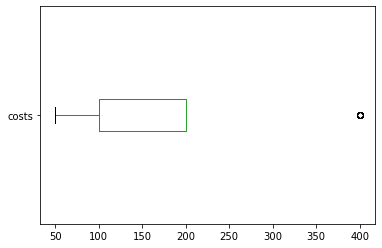

In [16]:
# Value distrubution: costs
log_csv.costs.plot(kind='box', vert=False)
plt.show()

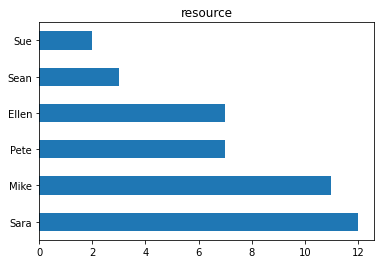

In [17]:
# Value counts: resource
log_csv.resource.value_counts().plot(y='resource', kind='barh', title='resource')
plt.show()

In [18]:
# All data
log_csv

,case_id,activity,timestamp,costs,resource
0,3,register request,2010-12-30 14:32:00+01:00,50,Pete
1,3,examine casually,2010-12-30 15:06:00+01:00,400,Mike
2,3,check ticket,2010-12-30 16:34:00+01:00,100,Ellen
3,3,decide,2011-01-06 09:18:00+01:00,200,Sara
4,3,reinitiate request,2011-01-06 12:18:00+01:00,200,Sara
5,3,examine thoroughly,2011-01-06 13:06:00+01:00,400,Sean
6,3,check ticket,2011-01-08 11:43:00+01:00,100,Pete
7,3,decide,2011-01-09 09:55:00+01:00,200,Sara
8,3,pay compensation,2011-01-15 10:45:00+01:00,200,Ellen
9,2,register request,2010-12-30 11:32:00+01:00,50,Mike


# 4. Event Log

## 4.1 Create Event Log

In [19]:
event_log = pm4py.format_dataframe(
    log_csv,
    case_id='case_id',
    activity_key='activity',
    timestamp_key='timestamp'
)

## 4.2 Inspect Event Log

In [20]:
event_log.head()

,case:concept:name,concept:name,time:timestamp,costs,resource,@@index
14,1,register request,2010-12-30 11:02:00+01:00,50,Pete,14
15,1,examine thoroughly,2010-12-31 10:06:00+01:00,400,Sue,15
16,1,check ticket,2011-01-05 15:12:00+01:00,100,Mike,16
17,1,decide,2011-01-06 11:18:00+01:00,200,Sara,17
18,1,reject request,2011-01-07 14:24:00+01:00,200,Pete,18


In [21]:
start_activities = pm4py.get_start_activities(event_log)
end_activities = pm4py.get_end_activities(event_log)

In [22]:
print(f'Start activities: {start_activities}')
print(f'End activities  : {end_activities}')

Start activities: {'register request': 6}
End activities  : {'reject request': 3, 'pay compensation': 3}


## 4.3. Export Event Log (to XES)

In [23]:
xes_exporter.apply(event_log, 'log/running-example.xes')

exporting log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

## 4.4. Import Event Log (from XES)

In [24]:
log = xes_importer.apply('log/running-example.xes')

parsing log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

## 4.5 Show Event Log

In [25]:
log # log_csv

[{'attributes': {'concept:name': '1'}, 'events': [{'concept:name': 'register request', 'time:timestamp': datetime.datetime(2010, 12, 30, 11, 2, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'costs': 50, 'resource': 'Pete', '@@index': 14}, '..', {'concept:name': 'reject request', 'time:timestamp': datetime.datetime(2011, 1, 7, 14, 24, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'costs': 200, 'resource': 'Pete', '@@index': 18}]}, '....', {'attributes': {'concept:name': '6'}, 'events': [{'concept:name': 'register request', 'time:timestamp': datetime.datetime(2011, 1, 6, 15, 2, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'costs': 50, 'resource': 'Mike', '@@index': 19}, '..', {'concept:name': 'pay compensation', 'time:timestamp': datetime.datetime(2011, 1, 16, 11, 47, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'costs': 200, 'resource': 'Mike', '@@index': 23}]}]

In [26]:
len(log) # len(set(log_csv.case_id))

6

In [27]:
log[2] # log_csv[log_csv.case_id == 3]

{'attributes': {'concept:name': '3'}, 'events': [{'concept:name': 'register request', 'time:timestamp': datetime.datetime(2010, 12, 30, 14, 32, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'costs': 50, 'resource': 'Pete', '@@index': 0}, '..', {'concept:name': 'pay compensation', 'time:timestamp': datetime.datetime(2011, 1, 15, 10, 45, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'costs': 200, 'resource': 'Ellen', '@@index': 8}]}

In [28]:
len(log[2]) # log_csv[log_csv.case_id == 3].shape[0]

9

In [29]:
log[2][-1] # log_csv[log_csv.case_id == 3].tail(1)

{'concept:name': 'pay compensation', 'time:timestamp': datetime.datetime(2011, 1, 15, 10, 45, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'costs': 200, 'resource': 'Ellen', '@@index': 8}

# 5. Process Mining

## 5.1 Alpha Miner

The Alpha Miner algorithm scans the traces (sequences in the event log) for ordering relations and builds the footprint matrix. Then, it converts the matrix into a [Petri net](https://en.wikipedia.org/wiki/Petri_net) (a type of graph). Process models modeled using Petri nets have a well-defined semantic: a process execution starts from the places included in the initial marking and finishes at the places included in the final marking.

Running Alpha Miner results in the following:

* a Petri net model in which all the transitions are visible, unique, and correspond to the classified events
* the initial marking — it describes the status of the Petri net model when the execution starts
* the final marking — it describes the status of the Petri net model when the execution ends

In [30]:
# Miner
net, initial_marking, final_marking = alpha_miner.apply(log)

### 5.1.1 Petri net

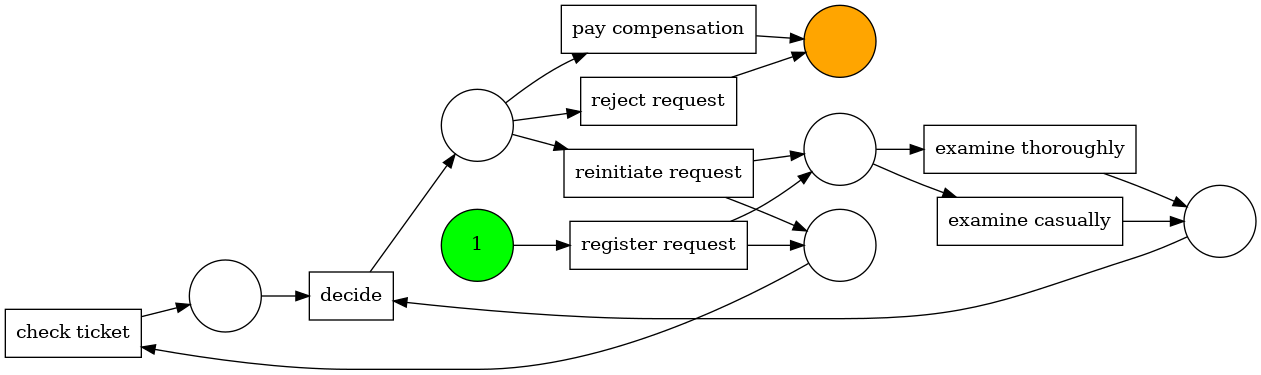

In [31]:
# GraphViz
gviz = pn_visualizer.apply(net, initial_marking, final_marking)

# Save
pn_visualizer.save(gviz, 'output/alpha_miner_pn.png')

# View
pn_visualizer.view(gviz)

Tip: For a more dense notation to create this visualisation, use an unpack operator:  

    pn_visualizer.view(pn_visualizer.apply(*alpha_miner.apply(log)))

### 5.1.2 Petri net with frequency information

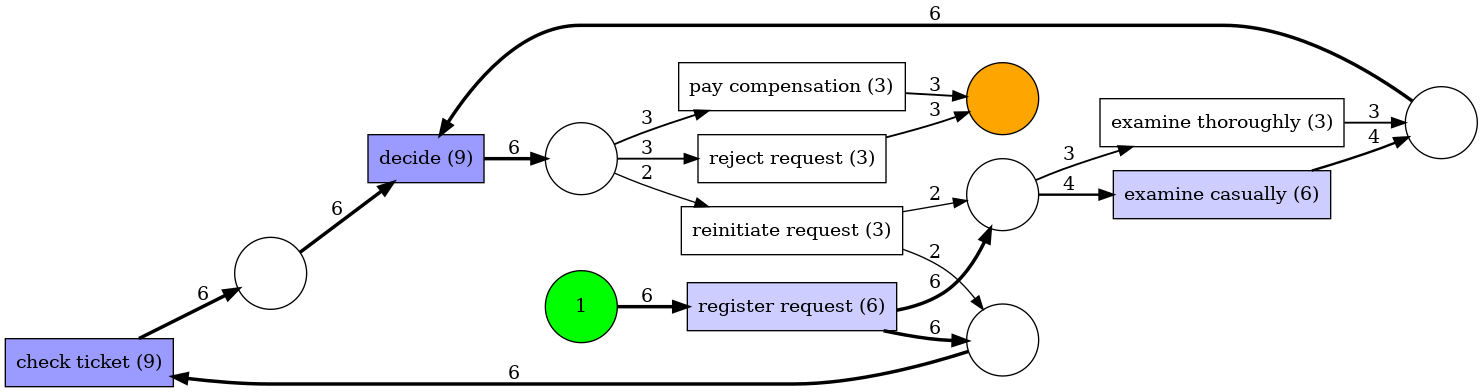

In [32]:
# Parameters
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: 'png'}

# GraphViz
gviz = pn_visualizer.apply(
    net, initial_marking, final_marking,
    parameters=parameters, 
    variant=pn_visualizer.Variants.FREQUENCY, 
    log=log
)

# Save
pn_visualizer.save(gviz, 'output/alpha_miner_pn_frequency.png')

# View
pn_visualizer.view(gviz)

To save the GraphViz in SVG-format, use:

In [33]:
# Parameters
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: 'svg'}

# GraphViz
gviz = pn_visualizer.apply(
    net, initial_marking, final_marking,
    parameters = parameters, 
    variant = pn_visualizer.Variants.FREQUENCY, 
    log = log
)

# Save
pn_visualizer.save(gviz, 'output/alpha_miner_pn_frequency.svg')

## 5.2 Directly-Follows Graph

Directly-Follows graphs are graphs where the nodes represent the events/activities in the log and directed edges are present between nodes if there is at least a trace in the log where the source event/activity is followed by the target event/activity. On top of these directed edges, it is easy to represent metrics like frequency (counting the number of times the source event/activity is followed by the target event/activity) and performance (some aggregation, for example, the mean, of time inter-lapsed between the two events/activities).

### 5.2.1 Directly-Follows Graph (frequency)

In [34]:
# Miner
dfg = dfg_discovery.apply(log)

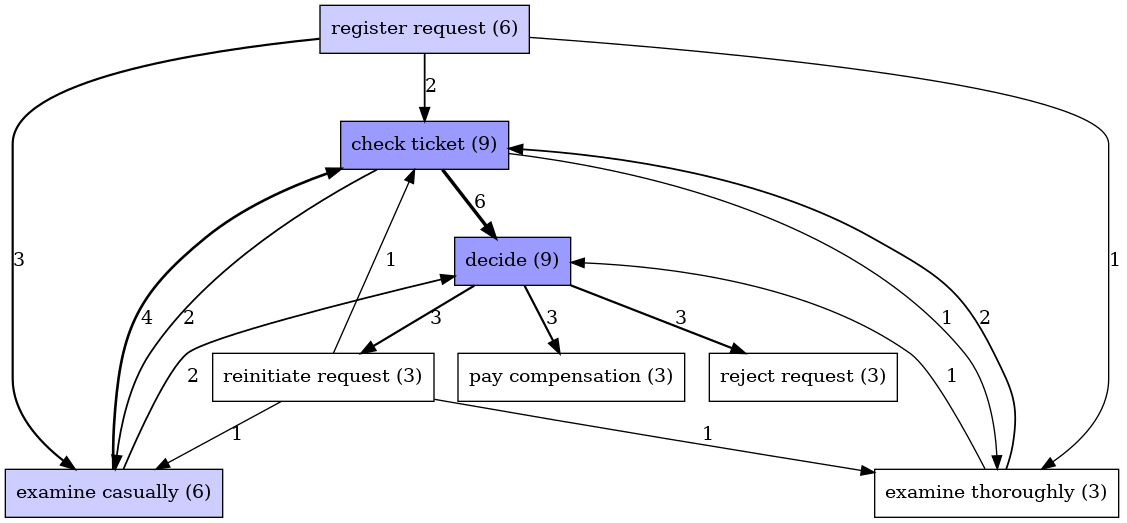

In [35]:
# GraphViz
gviz = dfg_visualization.apply(
    dfg,
    log = log,
    variant = dfg_visualization.Variants.FREQUENCY
)

# Save
dfg_visualization.save(gviz, 'output/dfg_frequency.png')

# View
dfg_visualization.view(gviz)

### 5.2.2 Directly-Follows Graph (performance)

Decorate the edges by using the performance metrics. By using the PERFORMANCE variant the average time elapsed between two nodes will be displayed.

In [36]:
# Miner
dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.PERFORMANCE)

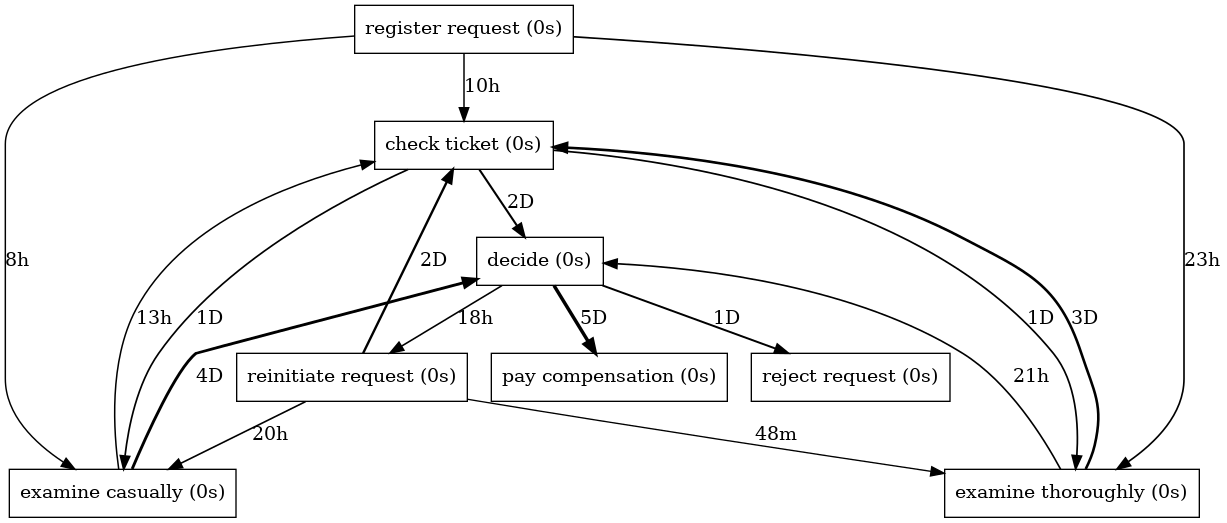

In [37]:
# GraphViz
gviz = dfg_visualization.apply(
    dfg,
    log = log,
    variant = dfg_visualization.Variants.PERFORMANCE
)

# Save
dfg_visualization.save(gviz, 'output/dfg_performance.png')

# View
dfg_visualization.view(gviz)

## 5.3 Heuristic Miner

Heuristics Miner is an algorithm that acts on the Directly-Follows Graph, providing way to handle with noise and to find common constructs (dependency between two activities, AND). The output of the Heuristics Miner is an Heuristics Net, so an object that contains the activities and the relationships between them.

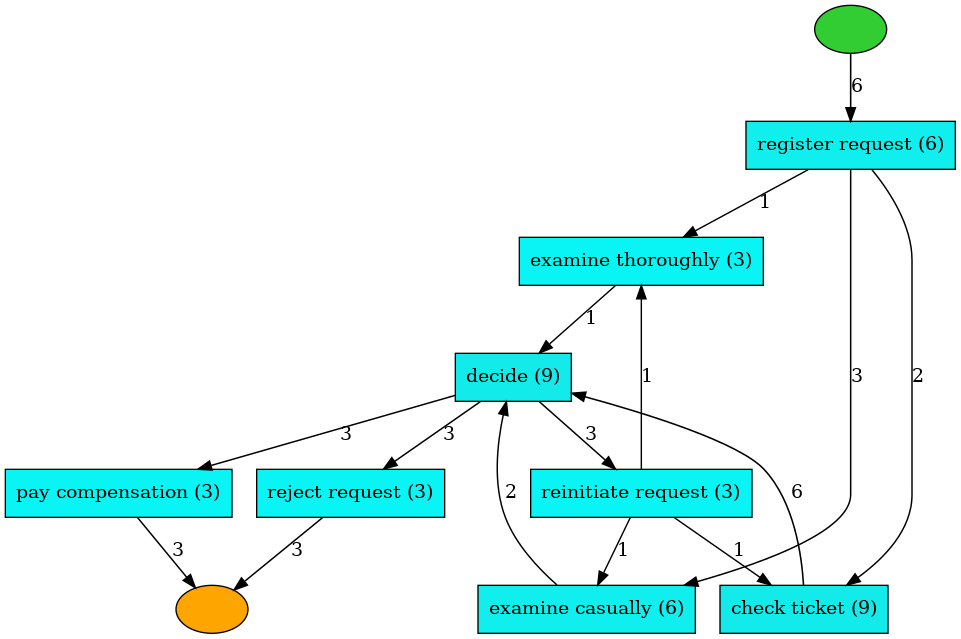

In [38]:
# Miner
heu_net = heuristics_miner.apply_heu(log)

# GraphViz
gviz = hn_visualizer.apply(heu_net)

# View
hn_visualizer.view(gviz)

Convert the Heuristics Net into a Petri net. The generated model is much more complex than the one generated by the Alpha Miner.

In [39]:
# Miner
net, initial_marking, final_marking = heuristics_miner.apply(log)

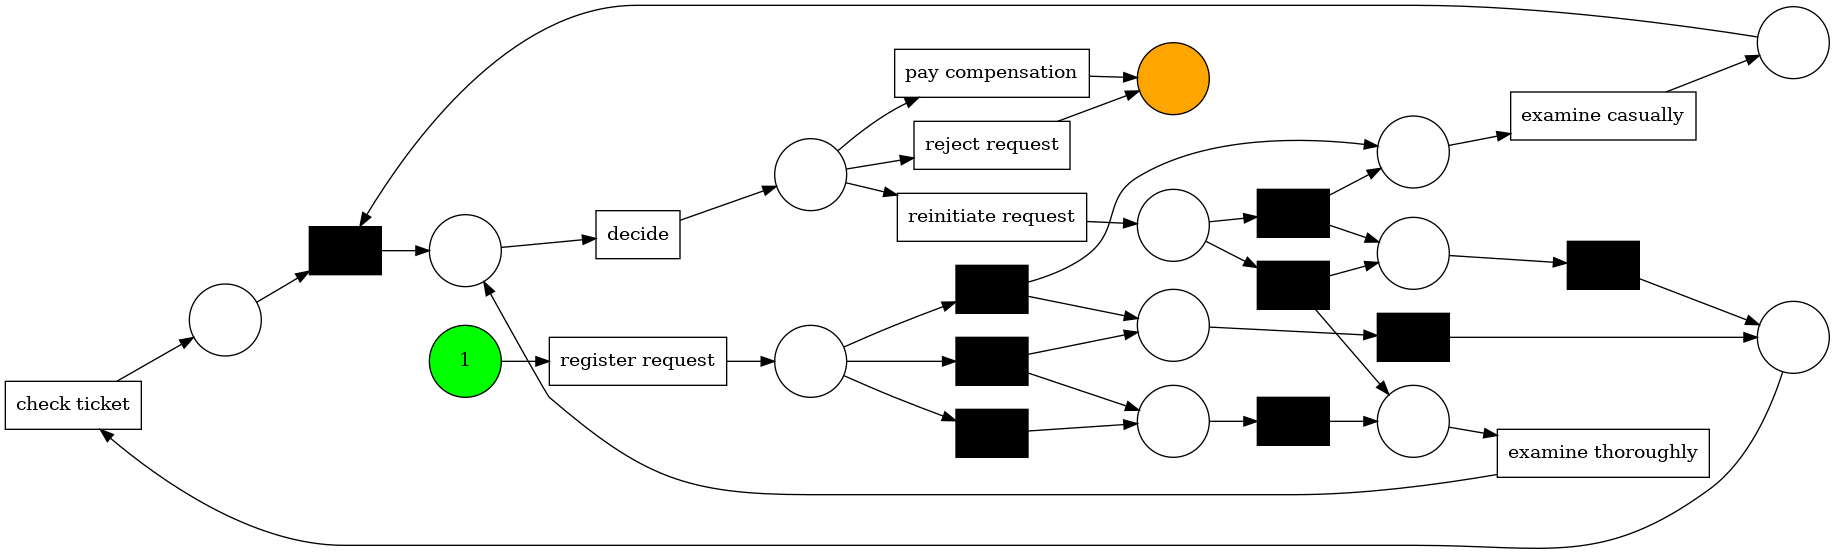

In [40]:
# GraphViz
gviz = pn_visualizer.apply(net, initial_marking, final_marking)

# View
pn_visualizer.view(gviz)

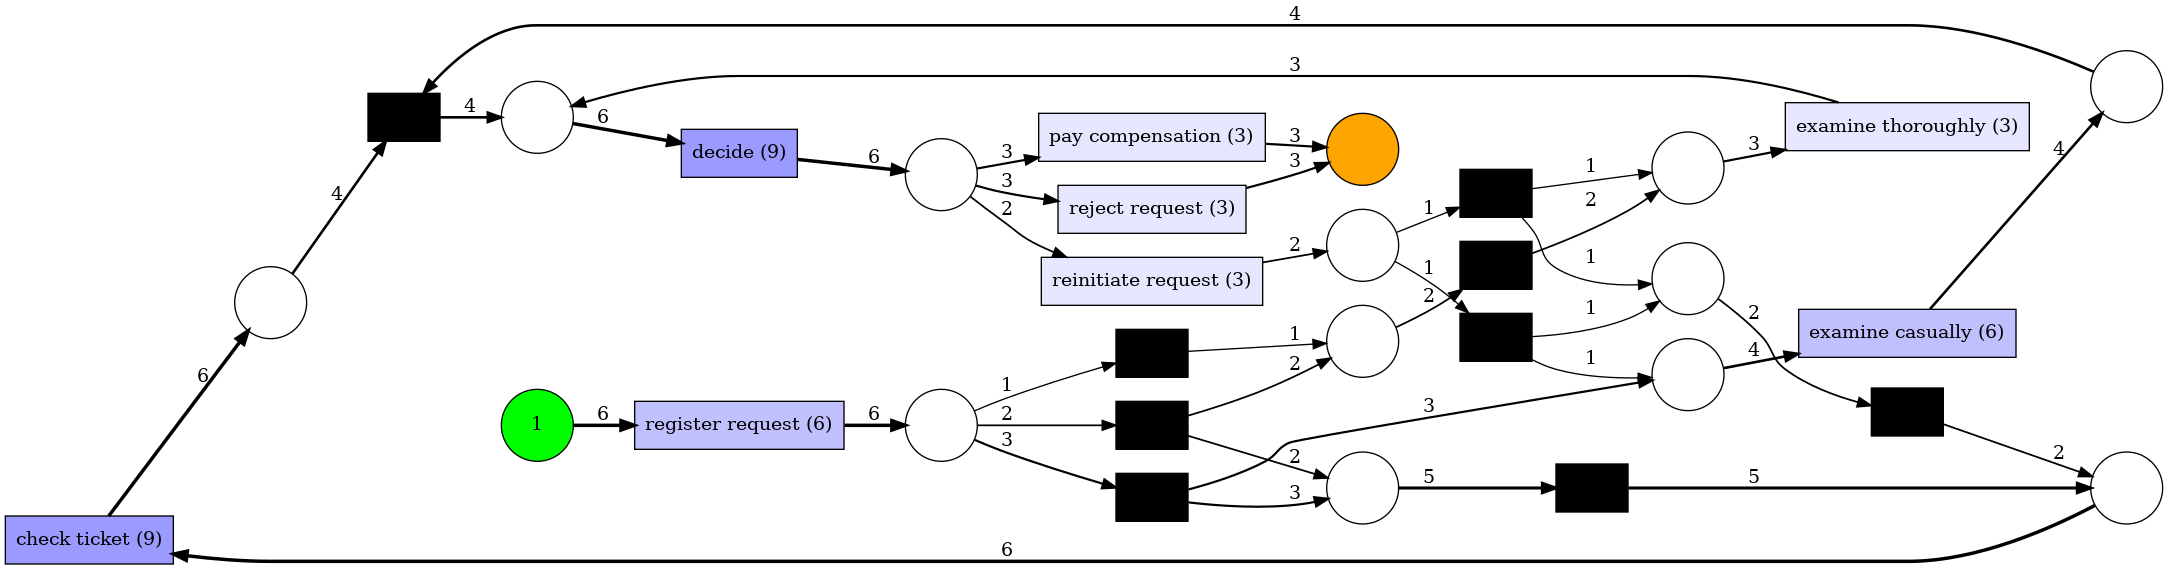

In [41]:
# GraphViz
gviz = pn_visualizer.apply(net, initial_marking, final_marking,
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)

# View
pn_visualizer.view(gviz)

## 5.4 Inductive Miner

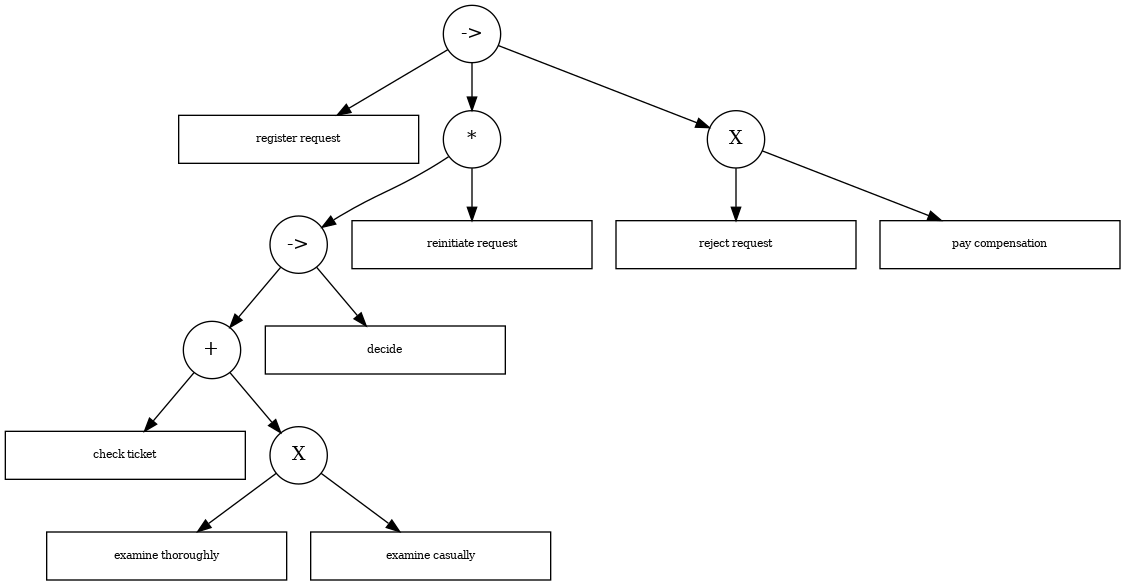

In [42]:
# Miner
tree = inductive_miner.apply_tree(log)

# GraphViz
gviz = pt_visualizer.apply(tree)

# View
pt_visualizer.view(gviz)

Convert the proces tree to a Petri net.

In [43]:
# Convert the process tree to a petri net
net, initial_marking, final_marking = pt_converter.apply(tree)

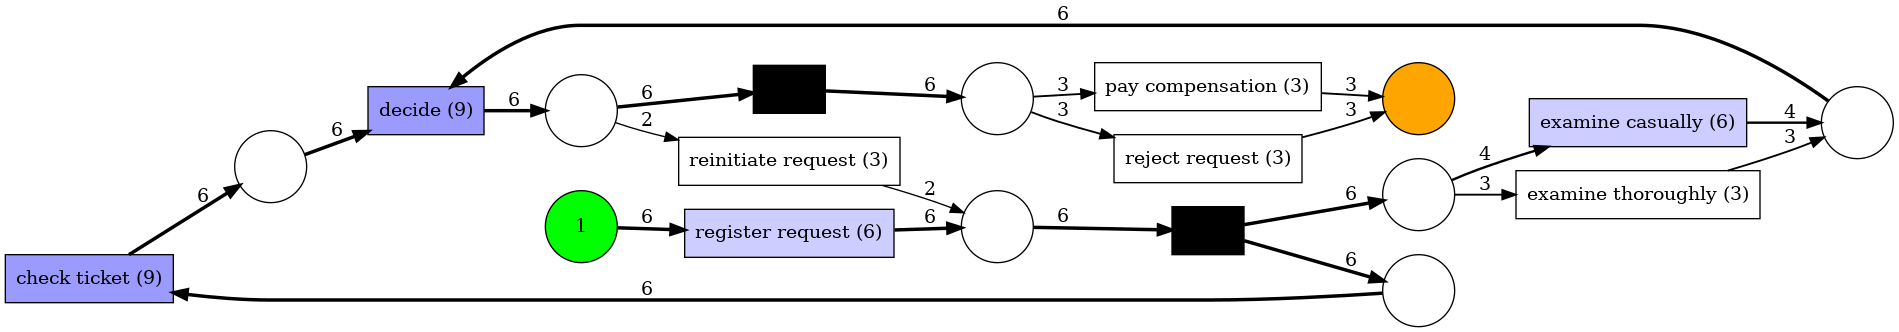

In [44]:
# Parameters
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: 'png'}

# GraphViz
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                           parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)

# View
pn_visualizer.view(gviz)

Or use the inductive miner to generate a Petri net from scratch.

In [45]:
# Miner
net, initial_marking, final_marking = inductive_miner.apply(log)

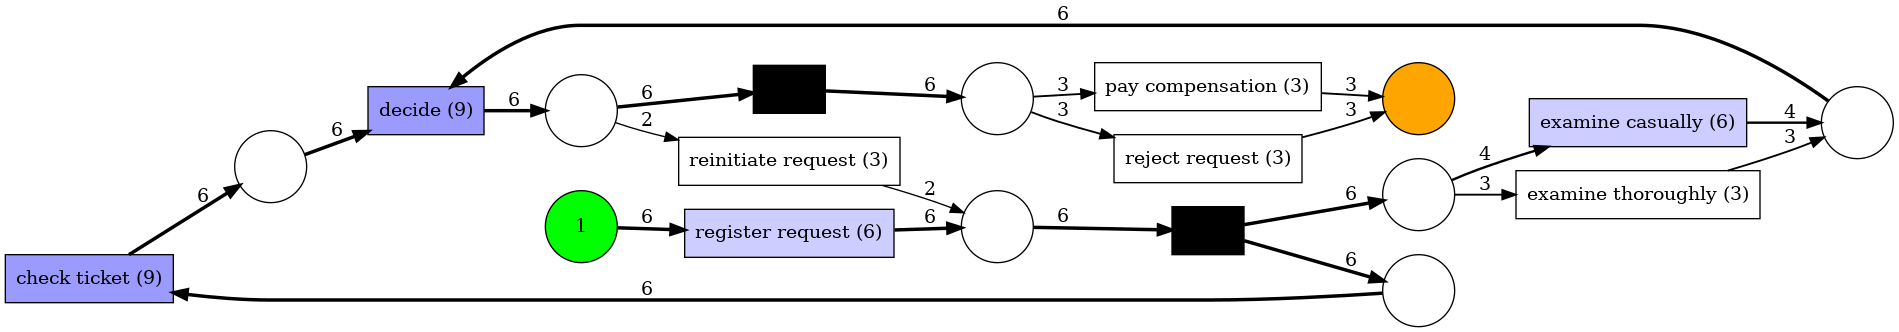

In [46]:
# Parameters
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: 'png'}

# GraphViz
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                           parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)

# View
pn_visualizer.view(gviz)

**Resources:**
- PM4PY [documentation](https://pm4py.fit.fraunhofer.de/documentation)
- Towards Data Science story [Introduction to Process Mining](https://towardsdatascience.com/introduction-to-process-mining-5f4ce985b7e5)
- Process Mining for Python on [Youtube](https://www.youtube.com/channel/UCRcgOKrDsntrTI78RXXliuw/videos)